In [1]:
import pickle
import anndata as ad
import scanpy as sc
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

In [3]:
metadata = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_metadata_cells.pkl', 'rb'))
metadata[metadata['kaggle_dataset'] == 'test_private']

In [4]:
pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_train.pkl', 'rb'))

In [5]:
private_test_input = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private.pkl', 'rb'))
private_test_input

In [6]:
private_test_input_raw = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl', 'rb'))
private_test_input_raw

In [7]:
private_test_target = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_prot_count_test_labels_private.pkl', 'rb'))
private_test_target

In [8]:
private_test_target_raw = pickle.load(open('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_prot_count_test_labels_private_raw.pkl', 'rb'))
private_test_target_raw

In [9]:
metadata_filtered = metadata[metadata.index.isin(private_test_input.index)]
metadata_filtered

In [10]:
private_test_input = ad.AnnData(private_test_input, obs=metadata_filtered)
private_test_target = ad.AnnData(private_test_target, obs=metadata_filtered)
private_test_input_raw = ad.AnnData(private_test_input_raw, obs=metadata_filtered)
private_test_target_raw = ad.AnnData(private_test_target_raw, obs=metadata_filtered)

# set gene names x2
private_test_input.var = private_test_input.var.reset_index()
private_test_input.var.index = [g.split('_')[1] for g in private_test_input.var.gene_ids.values]
private_test_input.var_names_make_unique()
private_test_input_raw.var = private_test_input_raw.var.reset_index()
private_test_input_raw.var.index = [g.split('_')[1] for g in private_test_input_raw.var.gene_ids.values]
private_test_input_raw.var_names_make_unique()

private_test_input

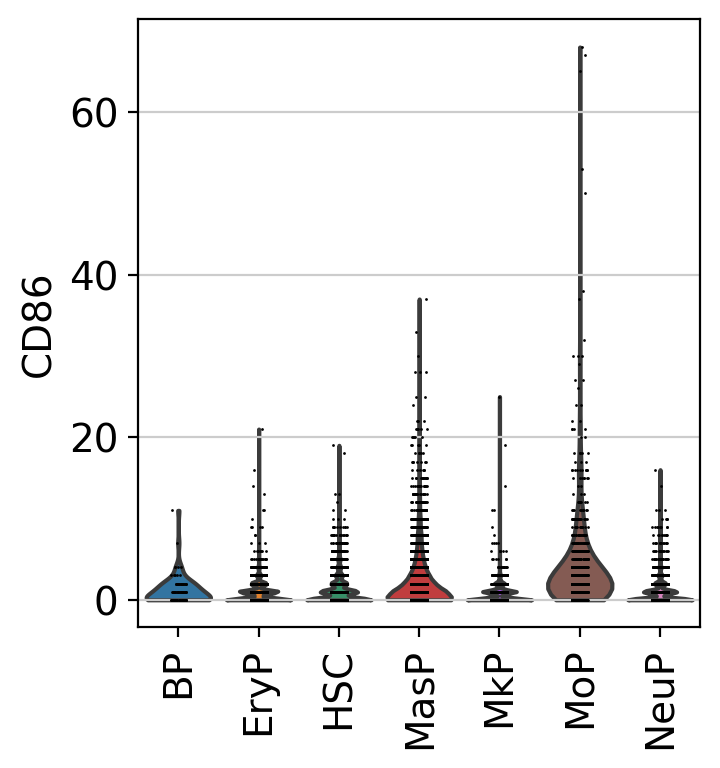

In [14]:
sc.pl.violin(private_test_target_raw, groupby='cell_type', keys=['CD86'], rotation=90)

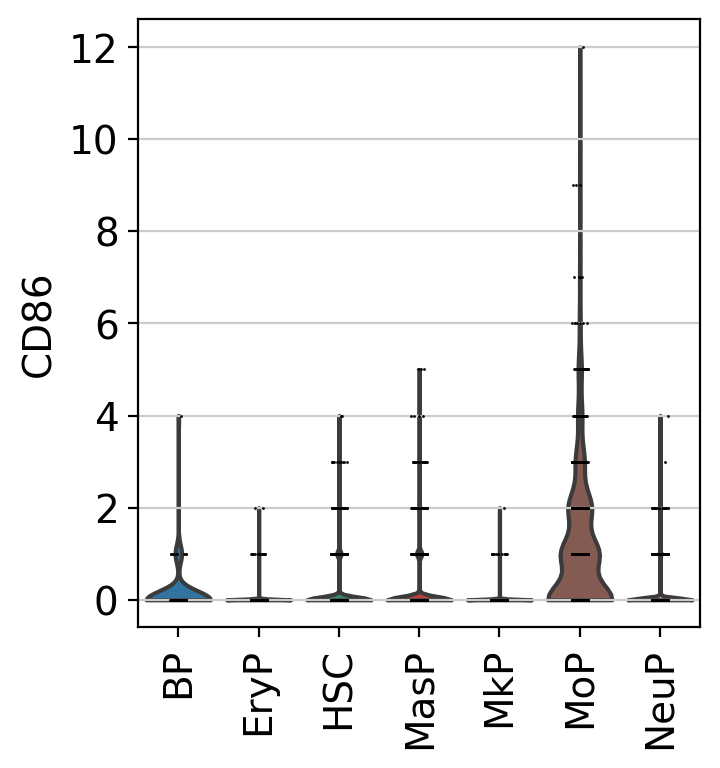

In [33]:
sc.pl.violin(private_test_input_raw, groupby='cell_type', keys=['CD86'], rotation=90)

In [15]:
%%time
pcorr = np.corrcoef(private_test_target.X, private_test_input.X.toarray(), rowvar=False)

/dss/dsshome1/02/di93zoj/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/dss/dsshome1/02/di93zoj/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


CPU times: user 3min 44s, sys: 19.1 s, total: 4min 3s
Wall time: 50.7 s


In [16]:
# note the dropna
corr_attrib = pd.DataFrame(pcorr[:140, -22085:], index=private_test_target.var_names, columns=private_test_input.var_names).T.dropna()

In [17]:
corr_attrib.sort_values(by='CD9')[['CD9']]

gene_ids,CD9
AC084033.3,-0.604212
MYB,-0.541534
RPL41,-0.540050
EEF1A1,-0.518730
RPS6,-0.517360
...,...
ITGB3,0.690659
GP1BA,0.699590
HPSE,0.701473
SELP,0.710308


Text(0.5, 0, 'correlation with CD86')

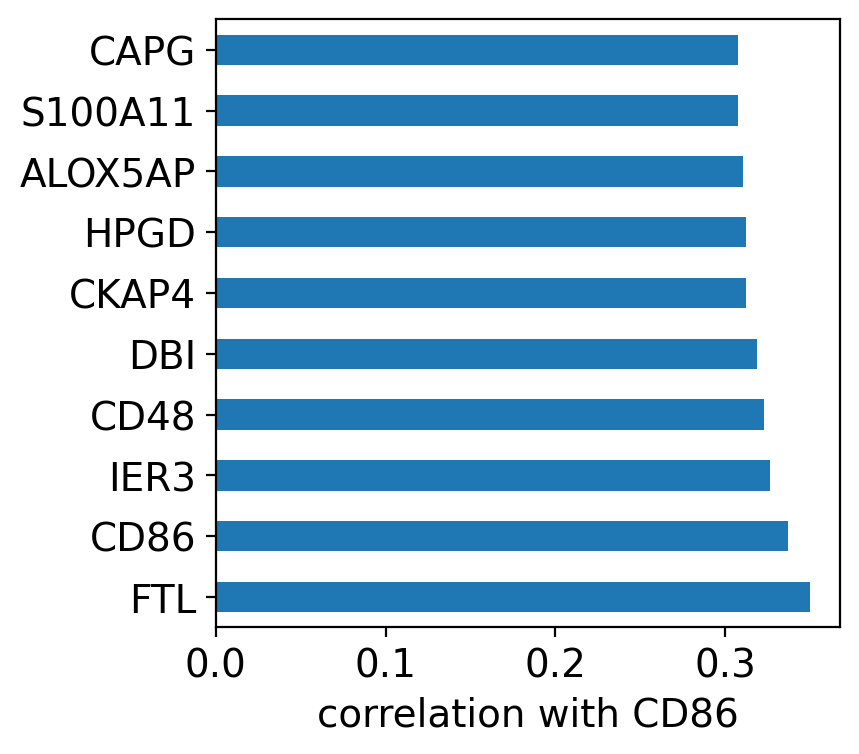

In [18]:
corr_attrib.sort_values(by='CD86', ascending=False)[['CD86']][:10].plot.barh(legend=None)
plt.grid(False)
plt.xlabel('correlation with CD86')

Text(0.5, 0, 'correlation with CD9')

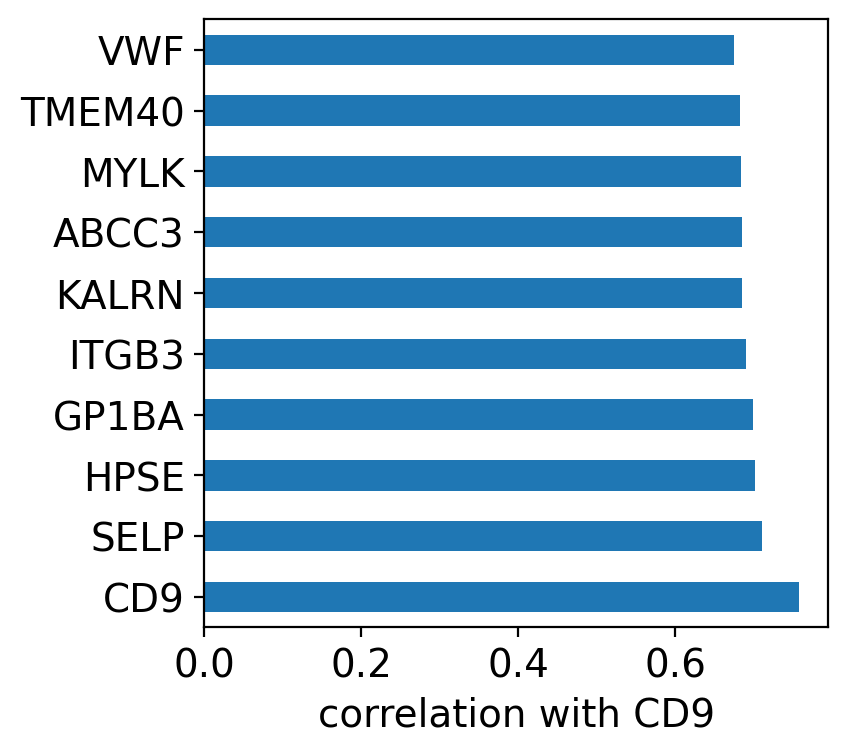

In [19]:
corr_attrib.sort_values(by='CD9', ascending=False)[['CD9']][:10].plot.barh(legend=None)
plt.grid(False)
plt.xlabel('correlation with CD9')

In [26]:
import sys
sys.path.append('../../..')
from utils import enrich

def plot_enrich(res):
    res['-log(p-value)'] = -np.log10(res['p_value'])
    sns.barplot(data=res, y='name', x='-log(p-value)', palette='Purples_r')
    plt.xlabel('-log(p-value)')
    plt.grid(False)

In [27]:
res = enrich(corr_attrib.sort_values(by='CD86', ascending=False).index[:20], corr_attrib.index.values)
res.head(20)

,name,p_value,intersections
0,response to external stimulus,0.000163,"[CD86, IER3, HPGD, ALOX5AP, LY96, LGALS1, ALB,..."
1,positive regulation of plasma membrane repair,0.001425,"[AHNAK, ANXA2]"
2,cell-cell adhesion,0.001425,"[CD86, S100A11, LGALS1, ITGB2, ANXA2, ANXA1, F..."
3,neutrophil activation,0.001425,"[ITGB2, ANXA1, FCGR2B]"
4,leukocyte activation involved in immune response,0.001425,"[CD86, LGALS1, ITGB2, ANXA1, FCGR2B]"
5,positive regulation of biological process,0.001425,"[CD86, IER3, DBI, HPGD, ALOX5AP, S100A11, LY96..."
6,inflammatory response,0.001425,"[IER3, ALOX5AP, LY96, LGALS1, ITGB2, ANXA1, FC..."
7,regulation of inflammatory response,0.001425,"[IER3, ALOX5AP, LGALS1, ANXA1, FCGR2B]"
8,cell activation involved in immune response,0.001425,"[CD86, LGALS1, ITGB2, ANXA1, FCGR2B]"
9,response to molecule of bacterial origin,0.001425,"[CD86, HPGD, LY96, VIM, FCGR2B]"


/tmp/ipykernel_3218595/3616993453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['-log(p-value)'] = -np.log10(res['p_value'])


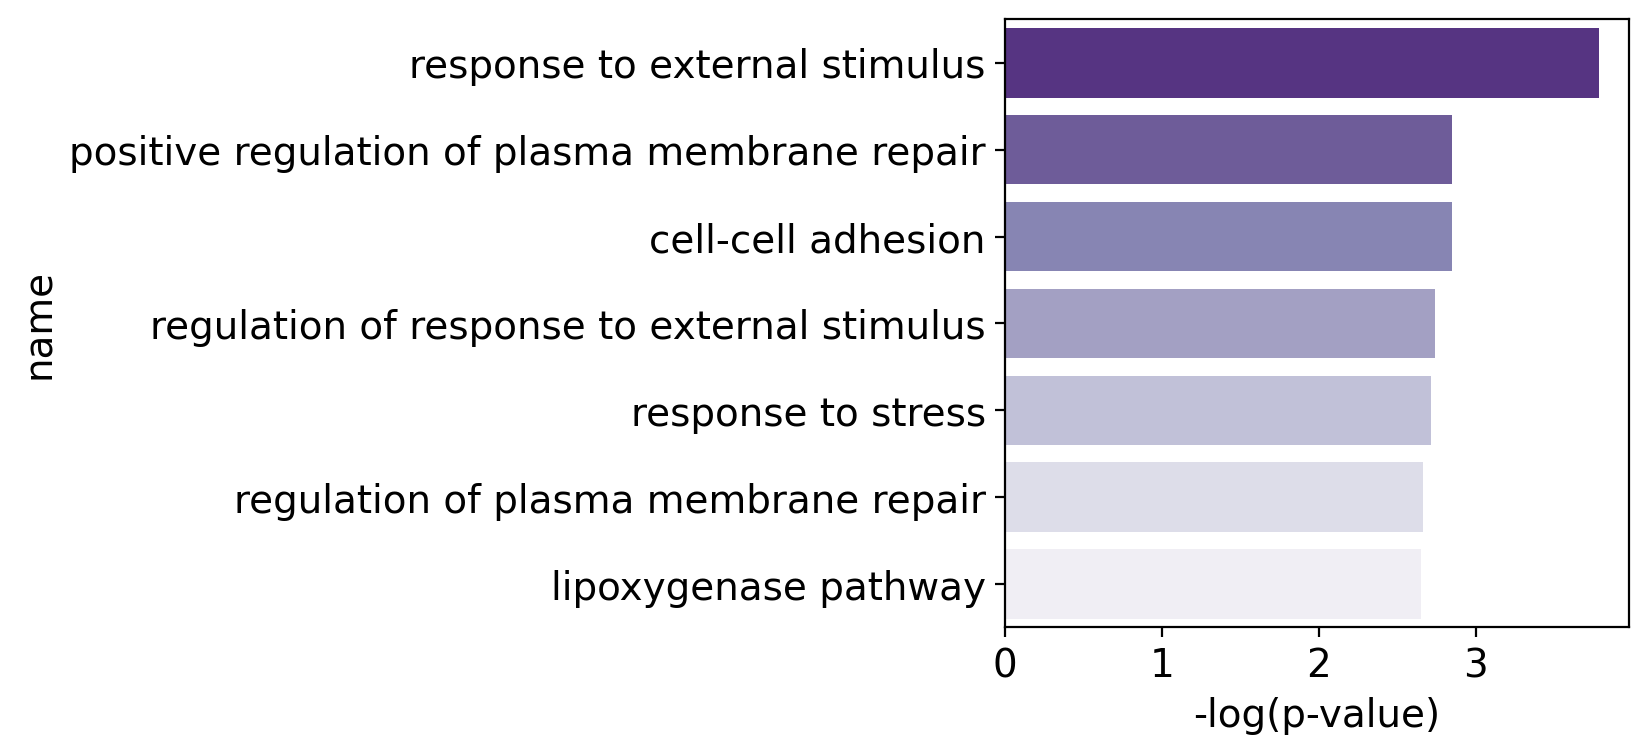

In [28]:
plot_enrich(res.iloc[[0, 1, 2, 11, 15, 16, 17]])

In [31]:
res = enrich(corr_attrib.sort_values(by='CD4', ascending=False).index[:20], corr_attrib.index.values)
res.head(20)

,name,p_value,intersections
0,defense response,2.696744e-09,"[CD4, FPR3, CLEC10A, MRC1, LY86, CD14, RBM47, ..."
1,immune response,4.244188e-08,"[CD4, FPR3, CLEC10A, MRC1, LY86, CD14, RBM47, ..."
2,inflammatory response,1.099577e-07,"[FPR3, LY86, CD14, CYBB, CSF1R, PLA2G7, CD163,..."
3,defense response to other organism,1.121051e-07,"[CD4, CLEC10A, MRC1, LY86, CD14, RBM47, CYBB, ..."
4,response to external stimulus,1.121051e-07,"[CD4, FPR3, CLEC10A, MRC1, LY86, CD14, RBM47, ..."
5,immune system process,1.299937e-07,"[CD4, FPR3, CLEC10A, MRC1, LY86, CD14, RBM47, ..."
6,biological process involved in interspecies in...,1.460527e-07,"[CD4, CLEC10A, MRC1, LY86, CD14, RBM47, CYBB, ..."
7,innate immune response,1.460527e-07,"[CLEC10A, MRC1, LY86, CD14, RBM47, CYBB, CSF1R..."
8,response to external biotic stimulus,5.342229e-07,"[CD4, CLEC10A, MRC1, LY86, CD14, RBM47, CYBB, ..."
9,response to other organism,5.342229e-07,"[CD4, CLEC10A, MRC1, LY86, CD14, RBM47, CYBB, ..."


/tmp/ipykernel_3218595/3616993453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['-log(p-value)'] = -np.log10(res['p_value'])


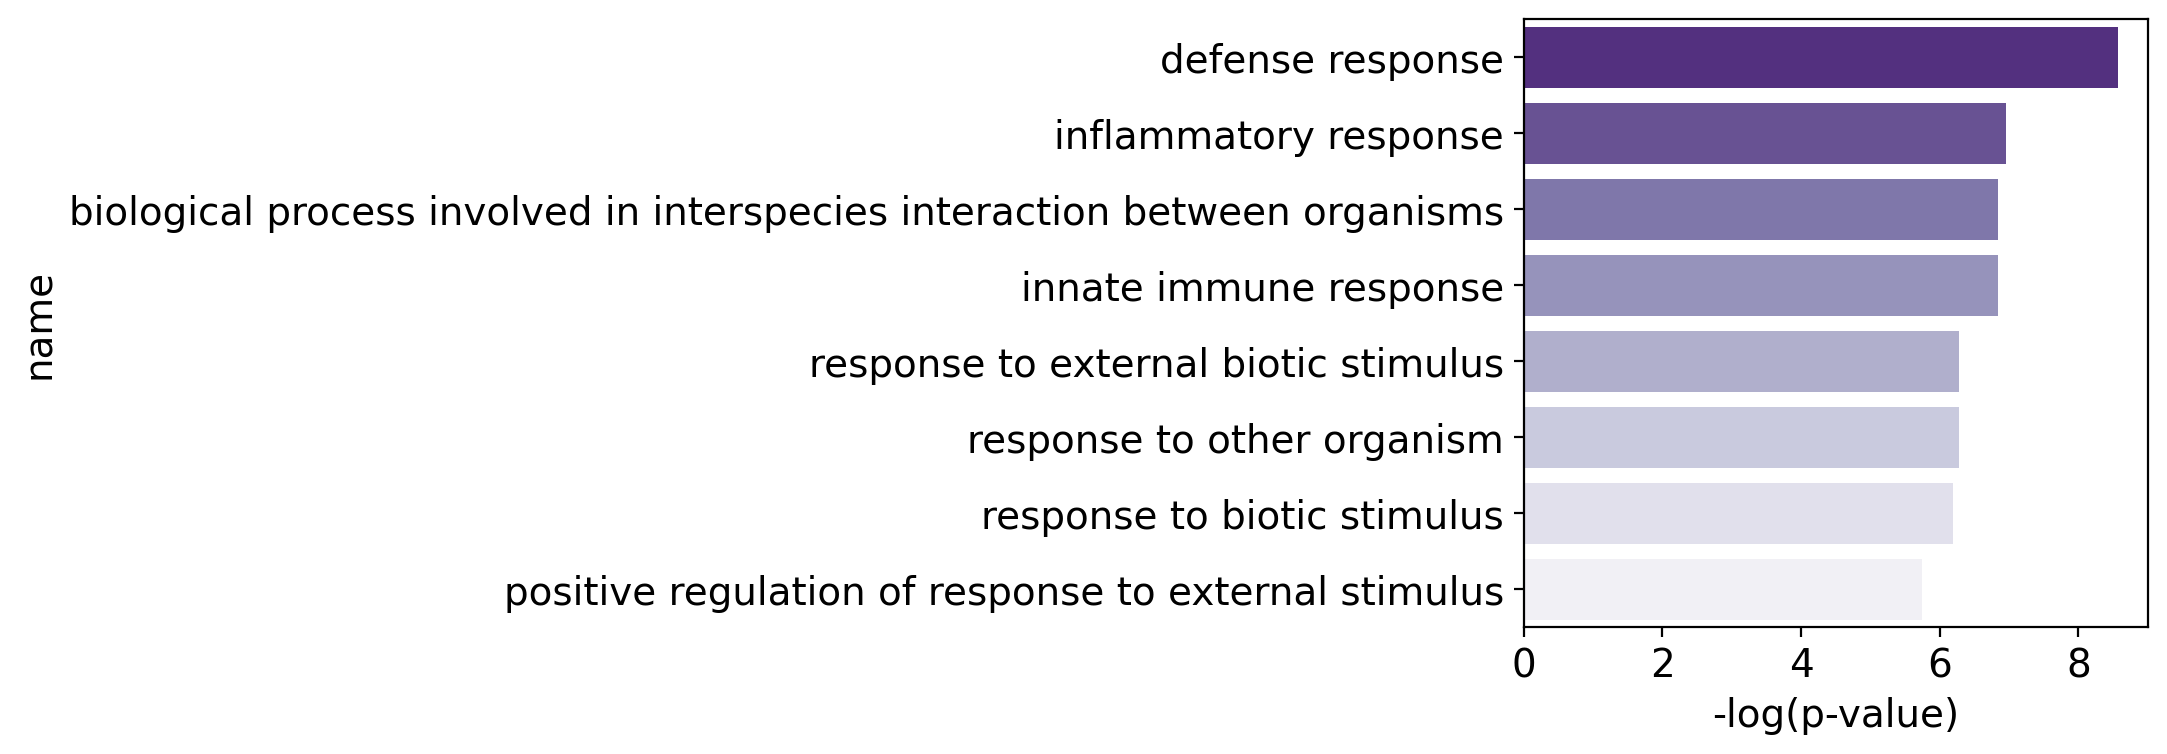

In [ ]:
plot_enrich(res.iloc[[0, 2, 6, 7, 8, 9, 10, 11]])